In [25]:
import re
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from scipy.linalg import solveh_banded 
from scipy.signal import savgol_filter
from sklearn.preprocessing import LabelEncoder
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import seaborn as sns
from scipy.optimize import nnls

In [27]:
class WhittakerSmoother(object):
    def __init__(self, signal, smoothness_param, deriv_order=1):
        """
        Whittaker Smoother.
        Input:
            signal: Array-like, the input signal to be smoothed.
            smoothness_param: Float, parameter controlling the smoothness.
            deriv_order: Integer, the order of the derivative used in smoothing.
        """
        self.y = signal
        assert deriv_order > 0, 'deriv_order must be an int > 0'
        # Compute the fixed derivative of identity (D).
        d = np.zeros(deriv_order * 2 + 1, dtype=int)
        d[deriv_order] = 1
        d = np.diff(d, n=deriv_order)
        n = self.y.shape[0]
        k = len(d)
        s = float(smoothness_param)
        # Create upper triangular banded matrix for smoothing operation.
        diag_sums = np.vstack([
            np.pad(s * np.cumsum(d[-i:] * d[:i]), ((k - i, 0),), 'constant')
            for i in range(1, k + 1)])
        upper_bands = np.tile(diag_sums[:, -1:], n)
        upper_bands[:, :k] = diag_sums
        for i, ds in enumerate(diag_sums):
            upper_bands[i, -i-1:] = ds[::-1][:i+1]
        self.upper_bands = upper_bands

    def smooth(self, w):
        """
        Perform the smoothing operation.
        Input:
            w: Array-like, weights for the smoothing process.
        Output:
            Array-like, smoothed signal.
        """
        foo = self.upper_bands.copy()
        foo[-1] += w  # last row is the diagonal
        try:
            smoothed_signal = solveh_banded(foo, w * self.y, overwrite_ab=True, overwrite_b=True)
        except np.linalg.LinAlgError:
            print("Numerical error in solveh_banded, assigning baseline with NaN.")
            smoothed_signal = np.full_like(self.y, np.nan)  # Return NaN if an error occurs
        return np.nan_to_num(smoothed_signal, nan=0.0, posinf=0.0, neginf=0.0)  # Replace NaN and Inf with 0

def als_baseline(intensities, asymmetry_param=0.001, smoothness_param=5e4,
                 max_iters=20, conv_thresh=1e-6, verbose=False, threshold_min_value=1e-6):
    """
    Asymmetric least squares baseline correction with threshold handling.
    Input:
        intensities: Array-like, original intensities of the signal.
        asymmetry_param: Float, parameter controlling asymmetry.
        smoothness_param: Float, parameter controlling smoothness.
        max_iters: Integer, maximum number of iterations.
        conv_thresh: Float, convergence threshold.
        verbose: Boolean, flag for verbose output.
        threshold_min_value: Float, minimum value below which data will be set to zero.
    Output:
        Array-like, baseline of the signal.
    """
    smoother = WhittakerSmoother(intensities, smoothness_param, deriv_order=2)
    p = asymmetry_param  # Rename for conciseness.
    w = np.ones(intensities.shape[0])  # Initialize weights.
    for i in range(max_iters):
        z = smoother.smooth(w)
        mask = intensities > z
        new_w = p * mask + (1 - p) * (~mask)
        conv = np.linalg.norm(new_w - w)
        if verbose:
            print(i+1, conv)
        if conv < conv_thresh:
            break
        w = new_w

    # Check for very small values and set them to zero
    z[np.abs(z) < threshold_min_value] = 0

    if np.isnan(z).any() or np.isinf(z).any():
        print("NaN or Inf values found in the adjusted baseline.")
        z = np.nan_to_num(z, nan=0.0, posinf=0.0, neginf=0.0)  # Replace NaN and Inf with 0
    return z

def find_baseline(df):
    """
    Apply baseline correction to each row in a DataFrame.
    Input:
        df: DataFrame, contains the spectral data.
    Output:
        DataFrame, baseline for each spectrum.
    """
    bl = df.copy()
    for i in range(len(df)):
        baseline = als_baseline(df.iloc[i, :].values)
        bl.iloc[i, :] = baseline
    return bl

def filter_by_peak_comparison(df, ref_column=800, target_column=920, factor=0.3):
    """
    Filter a DataFrame based on the intensity comparison between two specified columns.

    Args:
        df (pd.DataFrame): DataFrame containing spectral intensity columns.
        ref_column (int): Reference column for intensity comparison.
        target_column (int): Target column compared with the reference.
        factor (float): Factor added to the reference column to define the threshold.

    Returns:
        pd.DataFrame: Filtered DataFrame where the target column intensities are less than or equal to the sum of the reference column and the factor.
    """
    if ref_column in df.columns and target_column in df.columns:
        filter_mask = df[target_column] <= (df[ref_column] + factor)
        filtered_df = df[filter_mask].copy()  # Return a copy of the filtered DataFrame
    else:
        print(f"Columns {ref_column} cm-1 or {target_column} cm-1 not found in the DataFrame.")
        filtered_df = df.copy()  # Return a copy of the original DataFrame if columns do not exist
    return filtered_df

def validate_range(head, center):
    N = len(head)  # Number of elements in 'head'
    valid_indices = []  # List to store the indices of valid values
    left_limit = center - 15  # Lower limit of the range
    right_limit = center + 15  # Upper limit of the range
    for i in range(N):
        value = float(head[i])  # Convert the current value to float
        if left_limit < value < right_limit:  # Check if the value is within the range
            valid_indices.append(i)  # If within range, add the index to the list of valid indices
    return valid_indices  # Return the list of valid indices

def SNR(df, n):
    """
    Calculate the signal-to-noise ratio (SNR) and filter spectra with SNR greater than a given threshold.

    Args:
        df (pd.DataFrame): DataFrame with spectral data.
        n (int): Threshold for filtering based on SNR.

    Returns:
        tuple:
            - Series with the calculated SNR for each spectrum.
            - DataFrame with the filtered spectra having SNR greater than the threshold.
    """
    if not isinstance(df, pd.DataFrame):
        raise ValueError("Argument 'df' is not a DataFrame")

    # Define categorical columns to be removed
    categorical_columns = ["name", "t_exp", "date"]

    # Remove categorical columns if they exist in the DataFrame
    columns_to_remove = [col for col in categorical_columns if col in df.columns]
    df_spectra = df.drop(columns=columns_to_remove, errors='ignore')

    # Separate categorical columns if they existed
    df_labels = df[columns_to_remove] if columns_to_remove else None

    noise_head = validate_range(df_spectra.columns, 800)
    signal_head = validate_range(df_spectra.columns, 1000)

    if not noise_head or not signal_head:
        raise ValueError("Valid values for noise or signal were not found in the data")

    noise = df_spectra.iloc[:, noise_head]  # Get noise data
    signal = df_spectra.iloc[:, signal_head]  # Get signal data
    max_signal = signal.max(axis=1)  # Calculate the maximum signal value per row
    std_noise = noise.std(axis=1)  # Calculate the standard deviation of noise per row
    ratio = max_signal / std_noise  # Calculate the signal-to-noise ratio (SNR)

    high_snr = ratio[ratio > n]  # Filter ratios greater than the threshold

    high_snr_indices = high_snr.index.tolist()
    filtered_indices = [idx for idx in high_snr_indices if idx in df_spectra.index]

    # If no filtered indices are found, return an empty DataFrame
    if not filtered_indices:
        return ratio, pd.DataFrame()

    snr = df_spectra.loc[filtered_indices, :]

    # If there were categorical columns in the original DataFrame, concatenate them
    if df_labels is not None:
        snr = pd.concat([snr, df_labels.loc[snr.index]], axis=1)

    return ratio, snr  # Return the calculated SNR and the filtered DataFrame

def preprocess_data(X_filtered):
    """
    Preprocessing of spectral data.
    Input:
        X_filtered: DataFrame, raw spectral data.
    Output:
        Tuple of DataFrames: (preprocessed spectral data, baseline data).
    """
    # Apply Savitzky-Golay filter for smoothing.
    X_smooth = savgol_filter(X_filtered, 21, 2)
    X_smooth = pd.DataFrame(X_smooth, columns=X_filtered.columns)

    # Baseline correction.
    bl = find_baseline(X_smooth)
    X_corrected = X_smooth - bl  # Corrected data in original scale

    # Normalize each corrected spectrum.
    X_norm_list = []
    for _, row in X_corrected.iterrows():
        total = np.sum(row)
        if total != 0:
            X_norm_list.append(pd.DataFrame([row / total * 2000]))
        else:
            X_norm_list.append(pd.DataFrame([row]))
    X_norm = pd.concat(X_norm_list, ignore_index=True)

    # Standardize data.
    scaler = StandardScaler()
    z_numpy = X_norm.values
    z_numpy_scaled_rows = scaler.fit_transform(z_numpy.T).T
    X_norm_stdz = pd.DataFrame(data=z_numpy_scaled_rows, columns=X_filtered.columns)

    return X_norm_stdz, bl  # Return both the preprocessed data and the baseline

def standarization(df):
    """
    Preprocessing of spectral data.
    Input:
        df: DataFrame, raw spectral data.
    Output:
        DataFrame: Preprocessed spectral data with categorical data concatenated.
    """
    # Separate categorical columns
    coordinates = df[['X', 'Y']]
    categorical_data = df[['name', 'date', 't_exp', 'medium', 'especie']]
    df = df.drop(columns=['X', 'Y','name', 'date', 't_exp', 'medium', 'especie'])

    # Normalize each corrected spectrum
    X_norm_list = []
    for _, row in df.iterrows():
        total = np.sum(row)
        if total != 0:
            X_norm_list.append(pd.DataFrame([row / total * 2000]))
        else:
            X_norm_list.append(pd.DataFrame([row]))
    X_norm = pd.concat(X_norm_list, ignore_index=True)

    # Standardize data
    scaler = StandardScaler()
    z_numpy = X_norm.values
    z_numpy_scaled_rows = scaler.fit_transform(z_numpy.T).T
    X_norm_stdz = pd.DataFrame(data=z_numpy_scaled_rows, columns=df.columns)

    # Concatenate categorical columns back to the preprocessed DataFrame
    X_norm_stdz = pd.concat([coordinates, X_norm_stdz, categorical_data.reset_index(drop=True)], axis=1)

    return X_norm_stdz

def correct_year(date):
    date_str = str(date)
    if date_str.endswith('23'):
        return date_str[:-2] + '24'
    return date_str

def convert_date_format(date):
    if len(str(date)) == 5:
        date_str = '0' + str(date)  # Add 0 if it has 5 digits
    else:
        date_str = str(date)

    day = int(date_str[:2])
    month = int(date_str[2:4])
    year = int(date_str[4:])

    return pd.Timestamp(year=2000 + year, month=month, day=day)




def process_raman_folder(path):
    """
    Processes Raman spectrum data from a folder, considering only spectra with saturation 
    above 65,000 intensity around 3,000 cm⁻¹. Calculates the baseline after applying 
    all row elimination filters and performs interpolation without trimming the columns.

    Args:
        path (str): The path to the folder containing Raman spectrum data files.

    Returns:
        list: A list of tuples containing processed data for each file. Each tuple includes:
            - File name
            - Coordinates
            - Interpolated Raman spectra data (trimmed)
            - Preprocessed Raman spectra data (trimmed)
            - Trimmed Raman shift values
            - Complete baseline data (interpolated) after filters
    """
    folder_name = os.path.basename(path)
    pattern = re.compile(r'_(\d+(ms|s))_')
    t_exp_match = pattern.search(folder_name)
    t_exp = t_exp_match.group(1) if t_exp_match else "0"
    date = folder_name.split('_')[0]  # First sequence from 'name'

    csv_files = [f for f in os.listdir(path) if f.lower().endswith('.csv') and not f.lower().startswith('filtered_raw_spectra')]
    csv_files.sort()

    results = []

    for file in csv_files:
        df = pd.read_csv(os.path.join(path, file), engine='python', sep=',', skiprows=14, decimal='.')
        if df.empty:
            print(f"File {file} is empty or could not be read correctly.")
            continue

        if 'Unnamed: 1937' in df.columns:
            df = df.drop(columns=['Unnamed: 1937'])

        # Select only Raman shift columns (complete data)
        df2_full = df.iloc[:, 7:]
        df2_full = df2_full.drop_duplicates()

        row_indices_filtered = df2_full.index

        # Select the first two columns (coordinates) using these indices
        coordinates = df.iloc[row_indices_filtered, 0:2]
        coordinates.columns = ['X', 'Y']

        # (1) Filtering by Saturation in the 3200-3300 cm⁻¹ region
        region_3000_full = df2_full.loc[:, (df2_full.columns.astype(float) >= 3200) & (df2_full.columns.astype(float) <= 3300)]
        saturated_spectra_indices_full = region_3000_full.apply(lambda row: any(row > 65000), axis=1)

        # Filter spectra that do not saturate
        df2_full_filtered = df2_full[saturated_spectra_indices_full]
        coordinates_filtered = coordinates[saturated_spectra_indices_full]

        if df2_full_filtered.empty:
            print(f"No saturated spectra found in {file}.")
            continue

        # (2) Trim the range to 800-1600 cm⁻¹
        region_800_1600 = df2_full_filtered.loc[:, (df2_full_filtered.columns.astype(float) >= 800.0) & (df2_full_filtered.columns.astype(float) < 1600.0)]
        high_intensity_indices = region_800_1600.apply(lambda row: any(row > 65000), axis=1)

        region_800_1600 = region_800_1600[~high_intensity_indices]
        df2_full_filtered = df2_full_filtered[~high_intensity_indices]
        coordinates_filtered = coordinates_filtered[~high_intensity_indices]

        if region_800_1600.empty:
            print(f"All spectra in {file} were removed due to high intensity (>65,000) in the 800-1600 cm⁻¹ range.")
            continue

        # Trim complete spectrum to the range 50-3200 cm⁻¹
        df2_full_filtered_cut = df2_full_filtered.loc[:, (df2_full_filtered.columns.astype(float) >= 50) & (df2_full_filtered.columns.astype(float) <= 3200)]

        # Apply preprocessing and calculate baseline
        D0_BL, bl_full = preprocess_data(df2_full_filtered_cut)

        # Interpolate the full baseline (50-3200 cm⁻¹)
        full_new_wavenumbers = np.arange(50, 3200, 1)
        bl_full_interpolated = bl_full.apply(lambda row: np.interp(full_new_wavenumbers, df2_full_filtered_cut.columns.astype(float), row), axis=1)
        bl_full_interpolated_df = pd.DataFrame(bl_full_interpolated.tolist(), columns=full_new_wavenumbers, index=bl_full.index)

        # (4) Interpolate trimmed spectra (800-1600 cm⁻¹)
        corrected_wavenumbers = np.arange(800, 1600, 1)
        interpolated_data = [np.interp(corrected_wavenumbers, region_800_1600.columns.astype(float), spectrum) for spectrum in region_800_1600.values]
        interpolated_df = pd.DataFrame(interpolated_data, columns=corrected_wavenumbers, index=region_800_1600.index)

        # (5)(6)(7)(8) Preprocess the trimmed spectra
        D_PP, _ = preprocess_data(interpolated_df)

        if D_PP.empty:
            print(f"All spectra in {file} were removed during preprocessing.")
            continue

        # Check for NaNs
        if D_PP.isna().sum().sum() != 0:
            print("NaNs found in corrected data.")
        if interpolated_df.isna().sum().sum() != 0:
            print("NaNs found in original data.")
        if bl_full_interpolated_df.isna().sum().sum() != 0:
            print("NaNs found in baselines.")

        # Concatenate coordinates with the final DataFrames
        if not D_PP.empty:
            categorical_data = pd.DataFrame({
                'name': [folder_name] * len(D_PP),
                'date': [date] * len(D_PP),
                't_exp': [t_exp] * len(D_PP)
            })

            # Add coordinates to each processed DataFrame
            D_PP = pd.concat([coordinates_filtered.reset_index(drop=True), D_PP.reset_index(drop=True), categorical_data.reset_index(drop=True)], axis=1)
            interpolated_df = pd.concat([coordinates_filtered.reset_index(drop=True), interpolated_df.reset_index(drop=True), categorical_data.reset_index(drop=True)], axis=1)
            bl_full_interpolated_df = pd.concat([coordinates_filtered.reset_index(drop=True), bl_full_interpolated_df.reset_index(drop=True), categorical_data.reset_index(drop=True)], axis=1)

        # Append the results to the list with the fully interpolated baseline
        results.append((file, coordinates_filtered, interpolated_df, D_PP, bl_full_interpolated_df))

    return results



def process_main_folder(main_path, n):
    """
    Processes all subfolders in the main folder and filters spectra based on plastic percentages,
    SNR, and X calibration, applying row elimination filters to both corrected spectra and baselines.

    Args:
        main_path (str): Path to the main folder containing subfolders with Raman spectra data.
        n (int): Threshold for filtering based on SNR.

    Returns:
        tuple: (pd.DataFrame, pd.DataFrame, pd.DataFrame) - Accumulated preprocessed corrected spectra,
               complete baselines, and displacement statistics.
    """
    all_subfolders = [os.path.join(main_path, subfolder) for subfolder in os.listdir(main_path) if os.path.isdir(os.path.join(main_path, subfolder))]
    accumulated_corrected_spectra = pd.DataFrame()
    accumulated_full_baselines = pd.DataFrame()
    accumulated_original_spectra = pd.DataFrame()
    displacement_stats = {}  # Dictionary to store displacement statistics by 'date'

    folder = os.path.basename(os.path.normpath(main_path))

    # Display processing progress for subfolders
    for subfolder in tqdm(all_subfolders, desc=f'Processing folder {folder}', dynamic_ncols=True, leave=True):
        # Process each subfolder
        results = process_raman_folder(subfolder)
        for file, coordinates, interpolated_df, D_PP_full_filtered, bl_full_interpolated_filtered in results:
            total_spectra_initial = D_PP_full_filtered.shape[0]

            # Reset indices before extracting coordinates
            D_PP_full_filtered.reset_index(drop=True, inplace=True)
            interpolated_df.reset_index(drop=True, inplace=True)
            bl_full_interpolated_filtered.reset_index(drop=True, inplace=True)

            # Extract coordinates (common to all three DataFrames)
            coordinates = D_PP_full_filtered[['X', 'Y']]

            # Create categorical columns for this file
            categorical_data = interpolated_df[['name', 'date', 't_exp']]

            # Remove coordinate columns from the DataFrames
            D_PP_full_filtered = D_PP_full_filtered.drop(columns=['X', 'Y', 'name', 'date', 't_exp'])
            interpolated_df = interpolated_df.drop(columns=['X', 'Y', 'name', 'date', 't_exp'])
            bl_full_interpolated_filtered = bl_full_interpolated_filtered.drop(columns=['X', 'Y', 'name', 'date', 't_exp'])

            # (9) Filter by plastic coefficient > 1%
            # Read the pure spectra file (cyanobacteria and plastic) and transpose it
            pure_spectra = pd.read_csv(f'C:\\Users\\{user}\\OneDrive - UNICAN\\RamanNanoBase\\FITOPLANCTON_ESPECIES_UAM\\puros.csv').T

            cyan_coefficients = []
            plastic_coefficients = []
            rows_to_keep = []

            # Iterate over each spectrum in D_PP_full_filtered
            for idx, spectrum in D_PP_full_filtered.iterrows():
                # Apply nnls to each spectrum
                coefficients, _ = nnls(pure_spectra.T, spectrum)

                # Store coefficients for cyanobacteria and plastic
                cyan_coefficient = coefficients[0]
                plastic_coefficient = coefficients[1]

                cyan_coefficients.append(cyan_coefficient)
                plastic_coefficients.append(plastic_coefficient)

                # Filter rows where plastic percentage (coefficient B) is greater than 1%
                if plastic_coefficient < 0.02:
                    rows_to_keep.append(idx)  # Save rows to keep (plastic > 1%)

            # Apply the filter to keep only spectra meeting the criteria
            D_PP_filtered = D_PP_full_filtered.loc[rows_to_keep]
            interpolated_df_filtered = interpolated_df.loc[rows_to_keep]
            bl_full_interpolated_filtered_filtered = bl_full_interpolated_filtered.loc[rows_to_keep]
            coordinates = coordinates.loc[rows_to_keep]

            # Filter categorical columns to keep them synchronized
            categorical_data = categorical_data.loc[rows_to_keep]

            # (10) Filter by Signal-to-Noise Ratio (SNR)
            _, snr_result = SNR(D_PP_filtered, n)

            # Filter complete spectra, baselines, and categorical columns (remove rows only)
            preprocessed_full_spectra = D_PP_filtered.loc[snr_result.index]
            preprocessed_full_baselines = bl_full_interpolated_filtered_filtered.loc[snr_result.index]
            interpolated_df = interpolated_df_filtered.loc[snr_result.index]
            categorical_data = categorical_data.loc[snr_result.index]
            coordinates = coordinates.loc[snr_result.index]

            # (11) Filter by peak appearance at 920 cm⁻¹

            # Apply the filter to trimmed spectra (remove rows only) and keep baselines and categorical columns synchronized
            numeric_data = filter_by_peak_comparison(preprocessed_full_spectra, ref_column=800, target_column=920, factor=0.3)
            preprocessed_full_baselines = preprocessed_full_baselines.loc[numeric_data.index]
            interpolated_df = interpolated_df.loc[numeric_data.index]
            categorical_data = categorical_data.loc[numeric_data.index]
            coordinates = coordinates.loc[numeric_data.index]

            numeric_data.reset_index(drop=True, inplace=True)
            interpolated_df.reset_index(drop=True, inplace=True)
            preprocessed_full_baselines.reset_index(drop=True, inplace=True)
            categorical_data.reset_index(drop=True, inplace=True)
            coordinates.reset_index(drop=True, inplace=True)

            # (12) X Calibration: Shift spectra so that the maximum in the 994-1014 range is at 1004 cm⁻¹
            displacements = []  # To store the applied displacements
            for idx in numeric_data.index:
                spectrum = numeric_data.loc[idx]

                # Find the maximum in the 994-1014 cm⁻¹ region
                max_region = spectrum.loc[994:1014]  # Search for the maximum in the region
                max_position = max_region.idxmax()  # Get the position of maximum intensity
                shift = int(1004 - max_position)  # Calculate the displacement needed to align the peak at 1004 cm⁻¹
                displacements.append(shift)

                # Shift the corrected spectrum (numeric_data)
                numeric_data.iloc[idx] = np.roll(spectrum.values, shift).astype(float)

                # Apply the same displacement to the corresponding row in interpolated_df
                interpolated_df.iloc[idx] = np.roll(interpolated_df.iloc[idx].values, shift).astype(float)

            # Store displacement statistics by 'date'
            for unique_date in categorical_data['date'].unique():
                date_mask = categorical_data['date'] == unique_date
                filtered_displacements = pd.Series(displacements, index=numeric_data.index)[date_mask]
                displacement_counts = filtered_displacements.value_counts()

                if unique_date not in displacement_stats:
                    displacement_stats[unique_date] = displacement_counts.to_dict()
                else:
                    for shift, count in displacement_counts.items():
                        if shift in displacement_stats[unique_date]:
                            displacement_stats[unique_date][shift] += count
                        else:
                            displacement_stats[unique_date][shift] = count

            # (13) Trim the DataFrame to the 935-1575 cm⁻¹ range to avoid NaNs after calibration
            numeric_data = numeric_data.loc[:, (numeric_data.columns.astype(float) >= 935) & (numeric_data.columns.astype(float) <= 1575)]
            interpolated_df = interpolated_df.loc[:, (interpolated_df.columns.astype(float) >= 935) & (interpolated_df.columns.astype(float) <= 1575)]

            # Check for NaNs
            if numeric_data.isna().any().any() or interpolated_df.isna().any().any():
                print("Some DataFrames contain NaN values after trimming to 935-1575 cm⁻¹.")

            # Combine categorical columns after trimming
            corrected_spectra = pd.concat([coordinates, numeric_data, categorical_data], axis=1)
            original_spectra = pd.concat([coordinates, interpolated_df, categorical_data], axis=1)
            baselines_accumulated_full2 = pd.concat([coordinates, preprocessed_full_baselines, categorical_data], axis=1)

            # Check if all spectra were removed
            if corrected_spectra.empty:
                print(f"All spectra in {file} were removed after X calibration and range trimming.")
                continue

            # Accumulate preprocessed corrected spectra and baselines (without trimming or shifting)
            accumulated_corrected_spectra = pd.concat([accumulated_corrected_spectra, corrected_spectra], ignore_index=True)
            accumulated_full_baselines = pd.concat([accumulated_full_baselines, baselines_accumulated_full2], ignore_index=True)
            accumulated_original_spectra = pd.concat([accumulated_original_spectra, original_spectra], ignore_index=True)

    # Convert displacement statistics to a DataFrame for analysis
    displacement_stats_df = pd.DataFrame.from_dict(displacement_stats, orient='index').fillna(0)

    # Sort displacement columns in ascending order
    displacement_stats_df = displacement_stats_df.reindex(sorted(displacement_stats_df.columns, key=lambda x: int(x)), axis=1)
    displacement_stats_df['total'] = displacement_stats_df.sum(axis=1)

    # Add year correction in the 'date' column
    accumulated_corrected_spectra['date'] = accumulated_corrected_spectra['date'].apply(correct_year)
    accumulated_full_baselines['date'] = accumulated_full_baselines['date'].apply(correct_year)
    accumulated_original_spectra['date'] = accumulated_original_spectra['date'].apply(correct_year)

    # Sort by date
    accumulated_corrected_spectra = accumulated_corrected_spectra.sort_values(by=['date'], key=lambda col: col.apply(convert_date_format))
    accumulated_full_baselines = accumulated_full_baselines.sort_values(by=['date'], key=lambda col: col.apply(convert_date_format))
    accumulated_original_spectra = accumulated_original_spectra.sort_values(by=['date'], key=lambda col: col.apply(convert_date_format))

    return accumulated_corrected_spectra, displacement_stats_df



In [3]:
user = 'fmantecam'
n = 30

In [28]:
rutaUAM588_luer = f'C:\\Users\\{user}\\OneDrive - UNICAN\\RamanNanoBase\\FITOPLANCTON_ESPECIES_UAM\\unseens\\filtradoUAM588'
UAM588_luer, displacements_UAM588_luer = process_main_folder(rutaUAM588_luer, n)

rutaUAM588_CHAMBER = f'C:\\Users\\{user}\\OneDrive - UNICAN\\RamanNanoBase\\FITOPLANCTON_ESPECIES_UAM\\unseens\\Camara\\UAM588'
UAM588_CHAMBER, displacements_UAM588_CHAMBER = process_main_folder(rutaUAM588_CHAMBER, n)

rutaUAM588_MC_CHAMBER = f'C:\\Users\\{user}\\OneDrive - UNICAN\\RamanNanoBase\\FITOPLANCTON_ESPECIES_UAM\\unseens\\Camara\\UAM588_MedioCambiado'
UAM588_MC_CHAMBER, displacements_UAM588_MC_CHAMBER = process_main_folder(rutaUAM588_MC_CHAMBER, n)

rutaUAM502_luer = f'C:\\Users\\{user}\\OneDrive - UNICAN\\RamanNanoBase\\FITOPLANCTON_ESPECIES_UAM\\unseens\\filtradoUAM502'
UAM502_luer, displacements_UAM502_luer = process_main_folder(rutaUAM502_luer, n)

rutaUAM502_CHAMBER = f'C:\\Users\\{user}\\OneDrive - UNICAN\\RamanNanoBase\\FITOPLANCTON_ESPECIES_UAM\\unseens\\Camara\\UAM502_neubauer'
UAM502_CHAMBER, displacements_UAM502_CHAMBER = process_main_folder(rutaUAM502_CHAMBER, n)

rutaUAM502_MC_CHAMBER = f'C:\\Users\\{user}\\OneDrive - UNICAN\\RamanNanoBase\\FITOPLANCTON_ESPECIES_UAM\\unseens\\Camara\\UAM502_MedioCambiado'
UAM502_MC_CHAMBER, displacements_UAM502_MC_CHAMBER = process_main_folder(rutaUAM502_MC_CHAMBER, n)


Processing folder UAM502_MedioCambiado:  69%|██████▊   | 35/51 [01:24<00:21,  1.35s/it]

No saturated spectra found in 300924_UAM502MC_500ms_1acc_pw1_5um_37.CSV.


Processing folder UAM502_MedioCambiado: 100%|██████████| 51/51 [01:44<00:00,  2.05s/it]


In [ ]:
# Assign metadata to the DataFrames
UAM588_MC_CHAMBER['medium'] = 'BG11'
UAM588_MC_CHAMBER['species'] = 'UAM588_MC_neubauer'

UAM588_CHAMBER['medium'] = 'BG110'
UAM588_CHAMBER['species'] = 'UAM588_neubauer'

UAM588_luer['medium'] = 'BG110'
UAM588_luer['species'] = 'UAM588_luer'

UAM502_luer['medium'] = 'BG110'
UAM502_luer['species'] = 'UAM502_luer'

UAM502_MC_CHAMBER['medium'] = 'BG11'
UAM502_MC_CHAMBER['species'] = 'UAM502_MC_neubauer'

UAM502_CHAMBER['medium'] = 'BG110'
UAM502_CHAMBER['species'] = 'UAM502_neubauer'

# Concatenate the DataFrames
df_concatenated = pd.concat(
    [UAM588_CHAMBER, UAM588_MC_CHAMBER, UAM502_CHAMBER, UAM502_MC_CHAMBER, UAM502_luer, UAM588_luer], 
    ignore_index=True
)

# Save the concatenated DataFrame to a CSV file
save_path = f'C:\\Users\\{user}\\OneDrive - UNICAN\\RamanNanoBase\\FITOPLANCTON_ESPECIES_UAM\\ciano_neubauer_V091024.csv'
df_concatenated.to_csv(save_path, index=False)

# Display value counts for the 'species' column
df_concatenated['species'].value_counts()


especie
UAM502_luer           1459
UAM502_neubauer       1453
UAM588_luer           1441
UAM502_MC_neubauer    1435
UAM588_neubauer       1423
UAM588_MC_neubauer    1266
Name: count, dtype: int64

In [17]:
df = pd.read_csv('C:\\Users\\fmantecam\\OneDrive - UNICAN\\RamanNanoBase\\FITOPLANCTON_ESPECIES_UAM\\ciano_neubauer_V091024.csv')

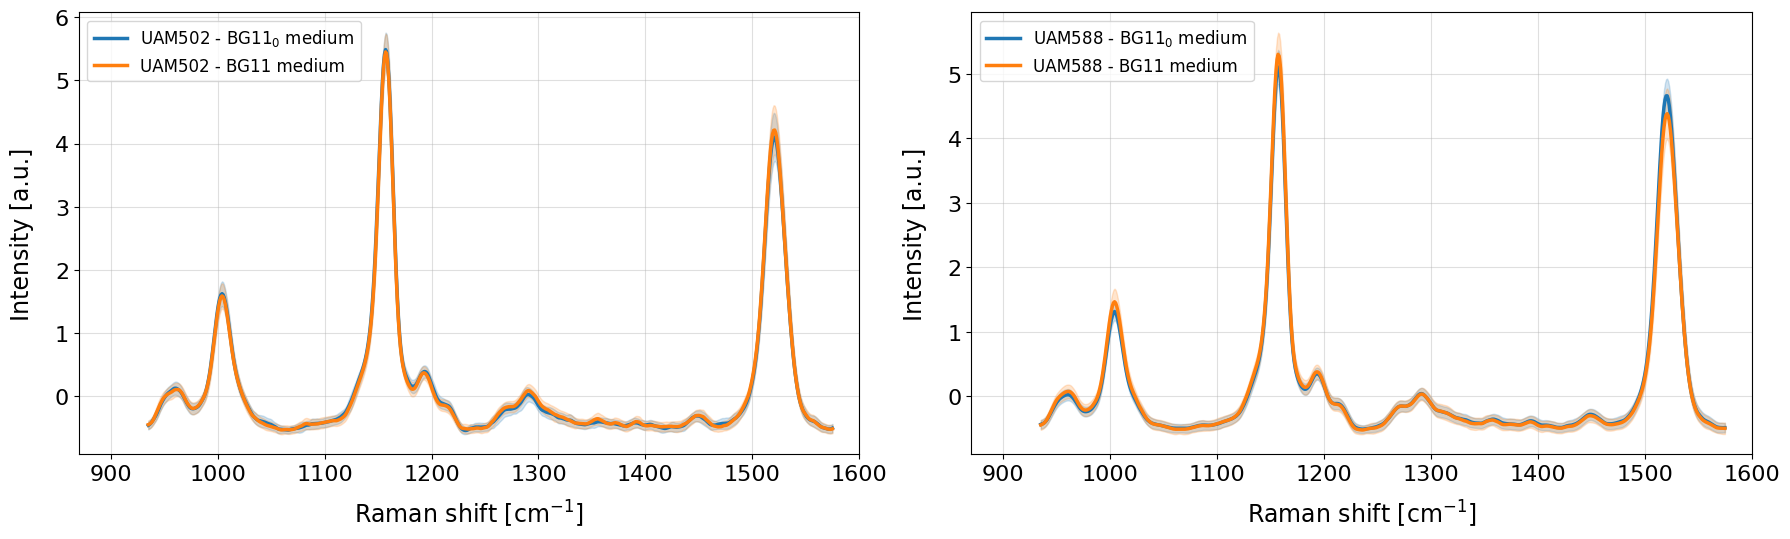

In [89]:
# Define the ranges for Raman Shifts
raman_shifts = np.arange(935, 1576, 1)

# Drop irrelevant columns
columns_to_drop = ['name', 't_exp', 'date', 'medium', 'especie']
df_numeric = df.drop(columns=columns_to_drop, errors='ignore')

# Filter species and culture mediums
uam502_bg110 = df[df['especie'] == 'UAM502_neubauer'].drop(columns=columns_to_drop, errors='ignore')
uam502_bg11 = df[df['especie'] == 'UAM502_MC_neubauer'].drop(columns=columns_to_drop, errors='ignore')
uam588_bg110 = df[df['especie'] == 'UAM588_neubauer'].drop(columns=columns_to_drop, errors='ignore')
uam588_bg11 = df[df['especie'] == 'UAM588_MC_neubauer'].drop(columns=columns_to_drop, errors='ignore')

# Calculate means and standard deviations
mean_uam502_bg110 = uam502_bg110.mean()
std_uam502_bg110 = uam502_bg110.std()

mean_uam502_bg11 = uam502_bg11.mean()
std_uam502_bg11 = uam502_bg11.std()

mean_uam588_bg110 = uam588_bg110.mean()
std_uam588_bg110 = uam588_bg110.std()

mean_uam588_bg11 = uam588_bg11.mean()
std_uam588_bg11 = uam588_bg11.std()

# Create the figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5.5))

# Subplot 1: UAM502
ax1.plot(raman_shifts, mean_uam502_bg110, label='UAM502 - BG11$_0$ medium', color='C0', lw=2.5)
ax1.fill_between(raman_shifts, mean_uam502_bg110 - std_uam502_bg110, mean_uam502_bg110 + std_uam502_bg110,
                 color='C0', alpha=0.2)
ax1.plot(raman_shifts, mean_uam502_bg11, label='UAM502 - BG11 medium', color='C1', lw=2.5)
ax1.fill_between(raman_shifts, mean_uam502_bg11 - std_uam502_bg11, mean_uam502_bg11 + std_uam502_bg11,
                 color='C1', alpha=0.2)
ax1.legend(loc='upper left', fontsize=12)
ax1.set_xlim(870, 1600)
ax1.set_xlabel('Raman shift [cm$^{-1}$]', fontsize=17, labelpad=10)
ax1.set_ylabel('Intensity [a.u.]', fontsize=17, labelpad=15)
ax1.tick_params(axis='both', which='major', labelsize=16)
ax1.grid(alpha=0.4)

# Subplot 2: UAM588
ax2.plot(raman_shifts, mean_uam588_bg110, label='UAM588 - BG11$_0$ medium', color='C0', lw=2.5)
ax2.fill_between(raman_shifts, mean_uam588_bg110 - std_uam588_bg110, mean_uam588_bg110 + std_uam588_bg110,
                 color='C0', alpha=0.2)
ax2.plot(raman_shifts, mean_uam588_bg11, label='UAM588 - BG11 medium', color='C1', lw=2.5)
ax2.fill_between(raman_shifts, mean_uam588_bg11 - std_uam588_bg11, mean_uam588_bg11 + std_uam588_bg11,
                 color='C1', alpha=0.2)
ax2.legend(loc='upper left', fontsize=12)
ax2.set_xlim(870, 1600)
ax2.set_xlabel('Raman shift [cm$^{-1}$]', fontsize=17, labelpad=10)
ax2.set_ylabel('Intensity [a.u.]', fontsize=17, labelpad=15)
ax2.tick_params(axis='both', which='major', labelsize=16)
ax2.grid(alpha=0.4)

ax1.text(0.93, 0.97, '(a)', transform=ax1.transAxes, fontsize=22, verticalalignment='top')
ax2.text(0.93, 0.97, '(b)', transform=ax2.transAxes, fontsize=22, verticalalignment='top')


# Adjust layout and display
plt.tight_layout()
#plt.savefig('C:\\Users\\fmantecam\\OneDrive - UNICAN\\Figuraspapercianos\\figureS5_meanspectra_cambiomedio.svg', format='svg', bbox_inches='tight', dpi=300)
#plt.savefig('C:\\Users\\fmantecam\\OneDrive - UNICAN\\Figuraspapercianos\\figureS5_meanspectra_cambiomedio.png', format='png', bbox_inches='tight', dpi=300)
plt.show()



Processing LDA for: Corrected Dataset


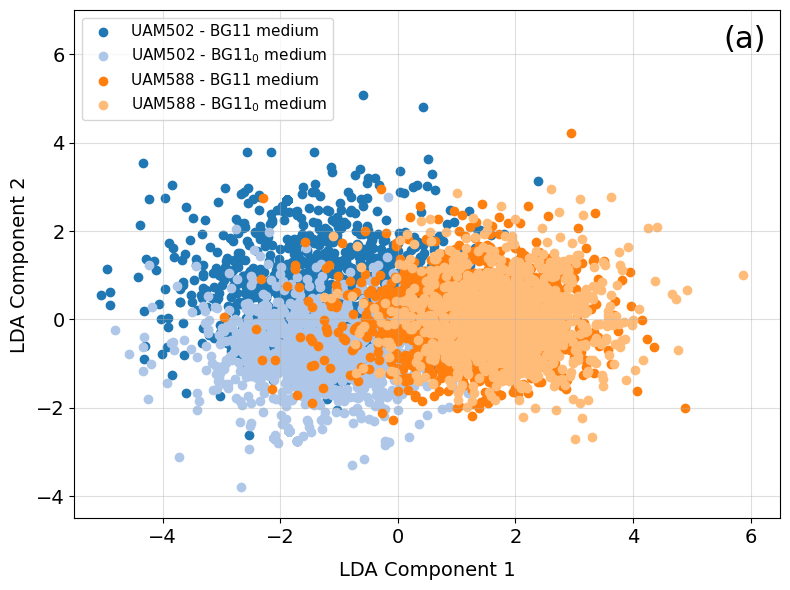

In [85]:

def process_and_plot_single_lda(dataset, file_name, ordered_classes=None, label='especie', custom_labels=None):
    """
    Applies LDA to a single dataset and plots the results with customizable labels.
    
    Args:
        dataset (DataFrame): The dataset to process.
        file_name (str): The file name for the dataset.
        ordered_classes (list of str): Desired order of classes for label encoding (optional).
        label (str): Column name containing the class labels (default is 'especie').
        custom_labels (dict): A dictionary to map original class labels to custom labels (optional).
    
    Returns:
        None
    """
    # Define colormap using Matplotlib's tab20
    colormap = plt.cm.tab20
    colors = colormap.colors  # Extract the list of colors

    print(f"Processing LDA for: {file_name}")

    # Remove unwanted classes
    dataset = dataset[~dataset[label].isin(['UAM502_luer', 'UAM588_luer'])]

    # Check if the label column exists
    if label not in dataset.columns:
        print(f"Warning: '{label}' not found in {file_name}")
        return

    # Extract labels
    y = dataset[label].values
    unique_classes_in_dataset = np.unique(y)

    # Use ordered_classes if provided and matches the dataset
    if ordered_classes and set(unique_classes_in_dataset).issubset(set(ordered_classes)):
        le = LabelEncoder()
        le.classes_ = np.array(ordered_classes)
        y_encoded = le.transform(y)
    else:
        le = LabelEncoder()
        y_encoded = le.fit_transform(y)

    # Drop irrelevant columns
    columns_to_drop = ['X', 'Y', 'name', 't_exp', 'date', 'medium', 'especie']
    columns_to_drop = [col for col in columns_to_drop if col in dataset.columns]
    X = dataset.drop(columns=columns_to_drop, axis=1)

    # Filter numeric columns
    X = X.select_dtypes(include=[np.number])

    # Check for sufficient numeric features
    if X.shape[1] < 2:
        print(f"Warning: Insufficient numeric features in {file_name} for LDA.")
        return

    # Check number of classes
    n_classes = len(np.unique(y_encoded))
    n_features = X.shape[1]
    max_components = min(n_features, n_classes - 1)

    if max_components < 2:
        print(f"Warning: Cannot calculate 2 LDA components for {file_name}. Only {max_components} component(s) can be calculated.")
        return

    # Apply LDA with two components
    lda = LinearDiscriminantAnalysis(n_components=2)
    X_lda = lda.fit_transform(X, y_encoded)

    # Create the plot
    fig, ax = plt.subplots(figsize=(8, 6))
    unique_labels = np.unique(y_encoded)
    for j, label_value in enumerate(unique_labels):
        # Get custom label if specified
        actual_label = le.inverse_transform([label_value])[0]
        if custom_labels and actual_label in custom_labels:
            actual_label = custom_labels[actual_label]

        X_label = X_lda[y_encoded == label_value]
        plt.scatter(X_label[:, 0], X_label[:, 1], label=actual_label, color=colors[j % len(colors)])

    # Configure the plot
    plt.xlabel('LDA Component 1', fontsize=14, labelpad=10)
    plt.ylabel('LDA Component 2', fontsize=14, labelpad=5)
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.legend(loc='upper left', fontsize=11)
    plt.ylim(-4.5, 7)
    plt.xlim(-5.5, 6.5)
    plt.grid(alpha=0.4)
    ax.text(0.92, 0.97, '(a)', transform=ax.transAxes, fontsize=22, verticalalignment='top')
    plt.tight_layout()
    #plt.savefig('C:\\Users\\fmantecam\\OneDrive - UNICAN\\Figuraspapercianos\\figureS6a_LDA_cambiomedio.svg', format='svg', bbox_inches='tight', dpi=300)
    #plt.savefig('C:\\Users\\fmantecam\\OneDrive - UNICAN\\Figuraspapercianos\\figureS6a_LDA_cambiomedio.png', format='png', bbox_inches='tight', dpi=300)
    plt.show()



# Custom labels for classes
custom_labels = {
    'UAM502_MC_neubauer': 'UAM502 - BG11 medium',
    'UAM502_neubauer': 'UAM502 - BG11$_0$ medium',
    'UAM588_MC_neubauer': 'UAM588 - BG11 medium',
    'UAM588_neubauer': 'UAM588 - BG11$_0$ medium'
}

# Execute the function
process_and_plot_single_lda(
    df, 
    "Corrected Dataset", 
    ordered_classes=['UAM502_MC_neubauer', 'UAM502_neubauer', 'UAM588_MC_neubauer', 'UAM588_neubauer'], 
    custom_labels=custom_labels
)


Loading model from C:\Users\fmantecam\OneDrive - UNICAN\Figuraspapercianos\cnn_model_cnn_model_mediocultivo3.h5...
Preprocessing data...
Generating predictions...
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Plotting confusion matrix...
Confusion matrix saved as C:\Users\fmantecam\OneDrive - UNICAN\Figuraspapercianos\figS6b_cm_3channels_sinletra.svg and C:\Users\fmantecam\OneDrive - UNICAN\Figuraspapercianos\figS6b_cm_3channels_sinletra.png


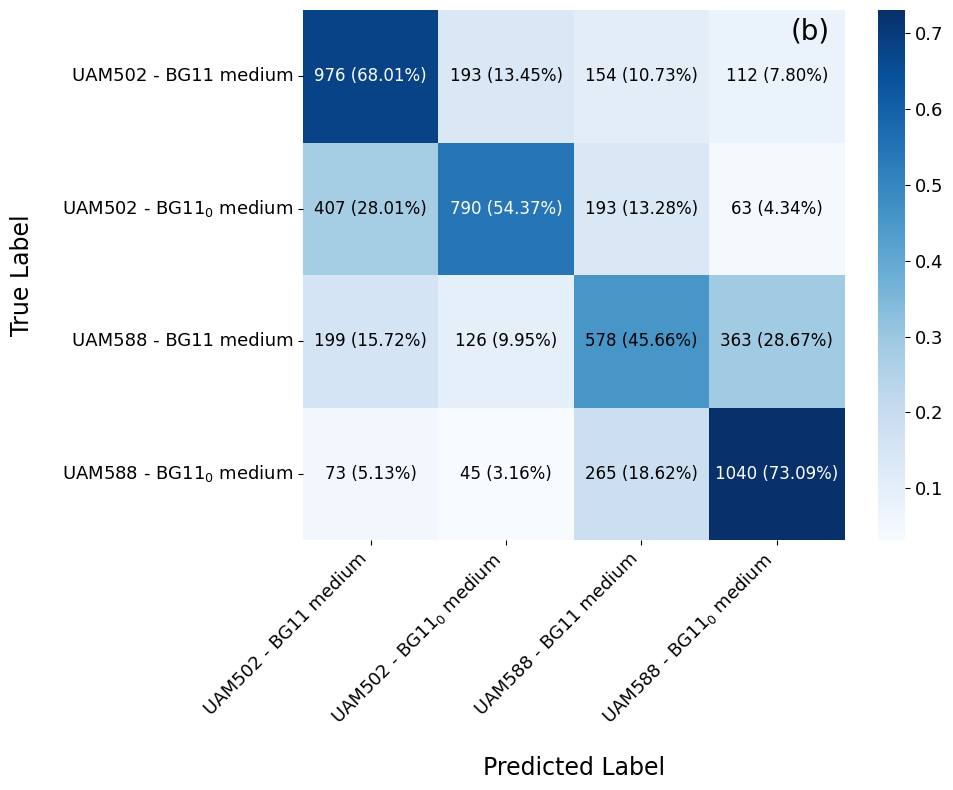

In [93]:
def load_and_evaluate_model(model_path, df, label_column, custom_labels, save_path):
    """
    Loads a trained model, evaluates it on the provided dataset, and plots a confusion matrix.

    Args:
        model_path (str): Path to the trained model (.h5 format).
        df (DataFrame): Dataset containing features and labels.
        label_column (str): Column name for the labels in the dataset.
        custom_labels (dict): Dictionary mapping encoded labels to custom labels.
        save_path (str): Path to save the confusion matrix figures.

    Returns:
        None
    """
    # Load the model
    print(f"Loading model from {model_path}...")
    model = tf.keras.models.load_model(model_path)

    # Preprocess the dataset
    print("Preprocessing data...")
    df = df[(df[label_column] != 'UAM502_luer') & (df[label_column] != 'UAM588_luer')]
    labels = df[label_column].values

    # Encode labels
    le = LabelEncoder()
    le.fit(labels)
    y_encoded = le.transform(labels)

    # Map custom labels
    custom_label_map = {i: custom_labels.get(cls, cls) for i, cls in enumerate(le.classes_)}

    # Convert labels to one-hot encoding
    num_classes = len(le.classes_)
    y_onehot = tf.keras.utils.to_categorical(y_encoded, num_classes=num_classes)

    # Extract features
    X = df.drop(columns=['X', 'Y', 'name', 't_exp', 'date', 'medium', label_column], errors='ignore').to_numpy()
    X = X.reshape(X.shape[0], X.shape[1], 1)  # Reshape for Conv1D input

    # Generate predictions
    print("Generating predictions...")
    y_pred = model.predict(X)
    y_pred_int = np.argmax(y_pred, axis=1)
    y_true_int = np.argmax(y_onehot, axis=1)

    # Compute confusion matrix
    cm = confusion_matrix(y_true_int, y_pred_int)
    cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)

    # Plot confusion matrix
    print("Plotting confusion matrix...")
    fig, ax = plt.subplots(figsize=(10, 8))
    sns_heatmap = sns.heatmap(
        cm_normalized, annot=False, fmt='.2%', cmap='Blues',
        xticklabels=[custom_label_map[i] for i in range(num_classes)],
        yticklabels=[custom_label_map[i] for i in range(num_classes)]
    )

    # Annotate confusion matrix
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            value = cm[i, j]
            if value != 0 and not np.isnan(cm_normalized[i, j]):
                text = f"{value} ({cm_normalized[i, j] * 100:.2f}%)"
                text_color = "white" if cm_normalized[i, j] > 0.5 else "black"
                plt.annotate(text, (j + 0.5, i + 0.5), ha='center', va='center', color=text_color, fontsize=12)

    # Configure plot
    ax.set_xlabel('Predicted Label', fontsize=17, labelpad=20)
    ax.set_ylabel('True Label', fontsize=17, labelpad=20)
    ax.text(0.9, 0.985, '(b)', transform=ax.transAxes, fontsize=20, verticalalignment='top')
    plt.xticks(rotation=45, fontsize=13, ha='right')
    plt.yticks(fontsize=13)
    cbar = sns_heatmap.collections[0].colorbar
    cbar.ax.tick_params(labelsize=13)
    plt.tight_layout()

    # Save confusion matrix
    cm_svg = f"{save_path}figS6b_cm_3channels_sinletra.svg"
    cm_png = f"{save_path}figS6b_cm_3channels_sinletra.png"
    #fig.savefig(cm_svg, format="svg", dpi=300)
    #fig.savefig(cm_png, format="png", dpi=300)
    print(f"Confusion matrix saved as {cm_svg} and {cm_png}")
    plt.show()


# Example usage
model_path = 'C:\\Users\\fmantecam\\OneDrive - UNICAN\\Figuraspapercianos\\cnn_model_cnn_model_mediocultivo3.h5'
dataset_path = 'C:\\Users\\fmantecam\\OneDrive - UNICAN\\RamanNanoBase\\FITOPLANCTON_ESPECIES_UAM\\TFMjorge\\ciano_neubauer_V091024.csv'
save_path = 'C:\\Users\\fmantecam\\OneDrive - UNICAN\\Figuraspapercianos\\'

custom_labels = {
    'UAM502_MC_neubauer': 'UAM502 - BG11 medium',
    'UAM502_neubauer': 'UAM502 - BG11$_0$ medium',
    'UAM588_MC_neubauer': 'UAM588 - BG11 medium',
    'UAM588_neubauer': 'UAM588 - BG11$_0$ medium'
}

df = pd.read_csv(dataset_path)

load_and_evaluate_model(
    model_path=model_path,
    df=df,
    label_column='especie',
    custom_labels=custom_labels,
    save_path=save_path
)

